# Demostración del módulo AitorEphemeris

In [1]:
using LittleEphemeris

Ejecutar la siguiente celda únicamente si no se tienen los datos descargados

In [ ]:
generate_files("/data/")

In [2]:
using JSON
using CSV
using SPICE
using DataFrames
using FFTW
using Plots
using BenchmarkTools

# Load leap seconds kernel
# Load a planetary ephemeris kernel
furnsh("data/naif0012.tls", "data/de440.bsp")

Primero comenzaremos con un intervalo de tiempo pequeño para comprobar que el csv tiene las dimensiones apropiadas y que los coeficientes son correctos. El intervalo abarcará doce intervalos de los ficheros de Spice.
Haremos la prueba con los planetas Mercurio y La Tierra.

In [3]:
ID_list = [1, 3]
time_interval = (utc2et("2022-01-01T12:00:00"), utc2et("2023-01-01T00:00:00"))
time_interval_list = fill(time_interval, 2)

create_coeffs_file("data/coeffs.json", "data/coeffs.csv", ID_list, time_interval_list)

"data/coeffs.csv"

- Mercurio tiene 4 set de polinomios de 14 coeficientes (en nuestro caso 16). Es decir que en la manera en la que guardamos los coeficientes debería ocupar: 2 filas por polinomio, por 4 sets de polinomios, por 6 tipos de coordenadas, por 12 intervalos. En total: 576 lineas.
- La Tierra tiene 2 sets de polinomios de 13 coeficientes (en nuestro caso 16). Es decir que en la manera en la que guardamos los coeficientes debería ocupar: 2 filas por polinomio, por 2 sets de polinomios, por 6 tipos de coordenadas, por 12 intervalos. En total: 288 lineas.

Es decir que en total el csv debería tener 864 filas y 8 columnas.

In [4]:
coeffs_df = CSV.read("data/coeffs.csv", DataFrame)
size(coeffs_df)

(864, 8)

Ahora pasaremos a evaluar los polinomios, ya que puede ser que el tamaño del fichero sea correcto pero la información de este no.

In [5]:
# Abrimos el fichero
coeffs_info = open("data/coeffs.json", "r")
# Generamos el vector de diccionarios
coeffs_info_vec = JSON.parse(coeffs_info)

# Intervalo de tiempo del segundo planeta
time_interval = coeffs_info_vec[2]["timeIntervals"]
# Numero de intervalos
n_intervals = length(time_interval)-1
# ID del cuerpo
ID = coeffs_info_vec[2]["bodyID"]

n = 10

# Generar vector de instantes de tiempo
tt = Vector{Float64}(undef, n_intervals*n)
for interval_index in 1:n_intervals
    # Instante de tiempo que evaluaremos
    range = (n*(interval_index-1)+1):(n*interval_index)
    tt[range] = rand(time_interval[interval_index]:time_interval[interval_index+1], n)
end

tt = sort(tt)

# Evaluar los coeficientes
x, y, z, vx, vy, vz = eval_coeffs_file("data/coeffs.json", "data/coeffs.csv", ID, tt);

Calculamos las efemerides con spice en los mismos nodos

In [6]:
# Vectores de coordenadas de SPICE
x_spc = Vector{Float64}(undef, n_intervals*n)
y_spc = Vector{Float64}(undef, n_intervals*n)
z_spc = Vector{Float64}(undef, n_intervals*n)
vx_spc = Vector{Float64}(undef, n_intervals*n)
vy_spc = Vector{Float64}(undef, n_intervals*n)
vz_spc = Vector{Float64}(undef, n_intervals*n)
coords_spc = [x_spc,y_spc,z_spc,vx_spc,vy_spc,vz_spc]

for i in 1:length(tt)
    t = tt[i]
    # Obtenemos el descriptor de segmento
    handle, descr, _ = spksfs(ID, t)
    # Obtenemos los valores en los nodos
    _, aux_vec, _ = spkpvn(handle, descr, t)
    # Guardamos los valores en sus respectivas Matrices
    x_spc[i] = aux_vec[1]
    y_spc[i] = aux_vec[2]
    z_spc[i] = aux_vec[3]
    vx_spc[i] = aux_vec[4]
    vy_spc[i] = aux_vec[5]
    vz_spc[i] = aux_vec[6]
end

Ahora calcularemos el error relativo

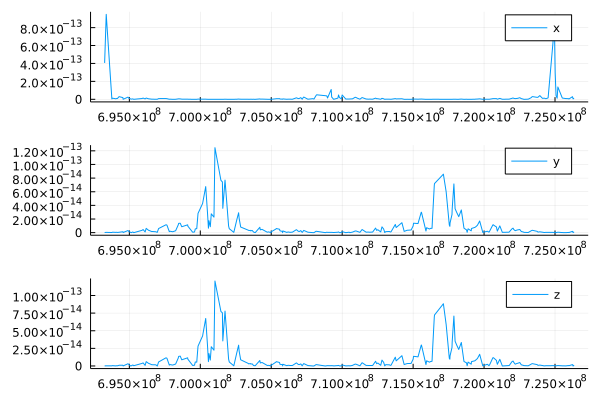

In [7]:
# Calculamos el error relativo
error_x = abs.(x-x_spc)./abs.(x_spc)
error_y = abs.(y-y_spc)./abs.(y_spc)
error_z = abs.(z-z_spc)./abs.(z_spc)

# Mostramos una gráfica del error
plx = plot(tt, error_x, label = "x")
ply = plot(tt, error_y, label = "y")
plz = plot(tt, error_z, label = "z")
plot(plx, ply, plz, layout = (3, 1))

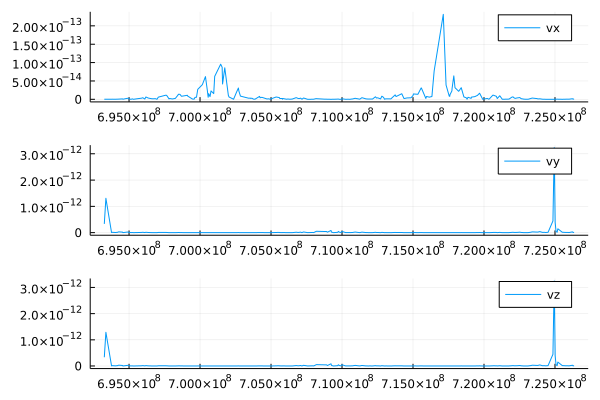

In [8]:
# Calculamos el error relativo
error_vx = abs.(vx-vx_spc)./abs.(vx_spc)
error_vy = abs.(vy-vy_spc)./abs.(vy_spc)
error_vz = abs.(vz-vz_spc)./abs.(vz_spc)

# Mostramos una gráfica del error
plvx = plot(tt, error_vx, label = "vx")
plvy = plot(tt, error_vy, label = "vy")
plvz = plot(tt, error_vz, label = "vz")
plot(plvx, plvy, plvz, layout = (3, 1))

Los resultados son los esperados, por lo que podemos decir que que el fichero de coeficientes es correcto.

La primera vez ha tardado bastante en crear el fichero, esto debido a que tenía que compilarse pero comprobemos cuanto tarda en crear un fichero mucho más grande. Haremos un fichero con todos los planetas del sistema solar, Plutón, el Sol y la Luna, en un intervalo de 50 años.

In [9]:
# Datos para generar el fichero
ID_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 301]
time_interval = (utc2et("2000-01-01T12:00:00"), utc2et("2050-01-01T12:00:00"))
time_interval_list = fill(time_interval, 11);

Para calcular el tiempo utilizaremos el paquete BenchmarkTools.

In [10]:
@btime create_coeffs_file("data/coeffs.json", "data/coeffs.csv", ID_list, time_interval_list)

  2.764 s (14824872 allocations: 786.93 MiB)


"data/coeffs.csv"

Comprobemos el tamaño del fichero

In [11]:
coeffs_df = CSV.read("data/coeffs.csv", DataFrame)
size(coeffs_df)

(147318, 8)

Podemos ver que ha tardado menos de 3 segundos en crear un fichero gigante, lo cual está bastante bien.

Ahora a partir de ese fichero crearemos uno más pequeño, utilizaremos los mismos datos que hemos usado para crear el primer fichero.

In [12]:
# Datos para generar el subfichero
ID_list = [1, 3]
time_interval = (utc2et("2022-01-01T12:00:00"), utc2et("2023-01-01T00:00:00"))
time_interval_list = fill(time_interval, 2)

generate_subfile("data/coeffs_subfile.json", "data/coeffs_subfile.csv", ID_list, time_interval_list, "data/coeffs.json", "data/coeffs.csv")

"data/coeffs_subfile.csv"

Comprobamos su tamaño.

In [13]:
coeffs_df = CSV.read("data/coeffs_subfile.csv", DataFrame)
size(coeffs_df)

(852, 8)

Nos podemos dar cuenta de que el tamaño no coincide con el primer fichero, podriamos pensar que está mal, sin embargo esto no es así. Esto se debe a que el primer fichero lo hemos generado a partir de los segmentos de coeficientes de SPICE mientras que el segundo lo hemos generado a partir de uno de nuestros ficheros. 

Para finalizar comprobaremos la estructura de coeficientes de un cuerpo especifico.

In [14]:
time_interval = (utc2et("2022-01-01T12:00:00"), utc2et("2023-01-01T00:00:00"))
Earth = BodyCoeffs("data/coeffs.json", "data/coeffs.csv", 3, time_interval);

Esta estructura tiene la funcionalidad para obtener el estado del ccuerpo en un instante específico, comprobemos que tal funciona comparando los resultados con los obtenidos mediante a SPICE.

In [15]:
t = utc2et("2022-05-17T10:45:00")
Earth(t)

6-element Vector{Float64}:
  -8.544574972585526e7
  -1.1508666828485271e8
  -4.985764531869727e7
  24.27267855162447
 -15.313492420396413
  -6.638221722858793

In [16]:
# Obtenemos el descriptor de segmento
handle, descr, _ = spksfs(3, t)
# Obtenemos los valores en los nodos
_, aux_vec, _ = spkpvn(handle, descr, t)

(1, [-8.5445749725855e7, -1.1508666828485286e8, -4.9857645318697326e7, 24.272678551624495, -15.313492420396363, -6.6382217228587725], 0)